In [170]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

import torch.optim as optim
import sys
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import solve_ivp

import math
srcdir='/Users/pengzhizhang/cellDancer/src'
sys.path.append(srcdir)
import celldancer.cdplt as cdplt

In [201]:
def jitter(U, S, scale=0.1):
    S = S + np.random.normal(loc=0.0, scale=scale, size=np.size(S))
    U = U + np.random.normal(loc=0.0, scale=scale, size=np.size(U))
    S1 = S[(S>0)&(U>0)]
    U1 = U[(S>0)&(U>0)]
    return U1, S1

def _simulate(u0, s0, alpha, beta, gamma, t, samples):
    def trans_dynamics(t, expr): 
        s = expr[0]
        u = expr[1]
        du_dt = alpha - beta*u
        ds_dt = beta*u - gamma*s
        return [ds_dt, du_dt]
    t_space = np.linspace(0, t, samples)
    #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
    num_sol = solve_ivp(trans_dynamics, [0, t], [s0, u0], method='RK45', dense_output=True)
    XY_num_sol = num_sol.sol(t_space)
    S, U = XY_num_sol[0], XY_num_sol[1]
    return U, S

def forward_simulate(alpha, beta, gamma, t, samples):
    '''forward start from (0, 0)'''
    return _simulate(0, 0, alpha, beta, gamma, t, samples)

def backward_simulate(u0, s0, beta, gamma, t, samples):
    #u0, s0 = alpha/beta, alpha/gamma
    return _simulate(u0, s0, 0, beta, gamma, t, samples)

def full_simulate(alpha, beta, gamma, t1, t2, samples1, samples2):
    U1, S1 = forward_simulate(alpha, beta, gamma, t1, samples1)
    U2, S2 = backward_simulate(np.max(U1), np.max(S1), beta, gamma, t2, samples2)
    return np.append(U1, U2), np.append(S1, S2)

class forwardModule(nn.Module):
    def __init__(self, alpha, beta, gamma):
        super(forwardModule, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        self.gamma = nn.Parameter(torch.tensor(gamma))
    def forward(self, u0, s0, dt):
        return u0 + (self.alpha - self.beta*u0)*dt, s0 + (self.beta*u0 - self.gamma*s0)*dt

scale1=1000
scale2=1000

class fullModule(nn.Module):
    def __init__(self, alpha, beta, gamma):
        super(fullModule, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        self.gamma = nn.Parameter(torch.tensor(gamma))
    def forward(self, u0, s0, dt):
        '''if u/s < gamma/beta, then alpha is zero
        '''
        region = u0-self.gamma/self.beta*s0
        #print(region)
        sig = nn.Sigmoid()
        u1 = u0 + (sig(region*scale1)*self.alpha - self.beta*u0)*dt
        s1 = s0 + (self.beta*u0 - self.gamma*s0)*dt
        return u1, s1

def init_parameters(u0, s0, cut=0.99):         
    un = np.quantile(u0, cut)
    sn = np.quantile(s0, cut)
    alpha = np.float32(un*sn)
    beta = np.float32(sn)
    gamma = np.float32(un)
    return alpha, beta, gamma

def cost_fn(u0, s0, u1, s1, indices, direct=None):
    """Cost function
    Args:
        direct: 1: positive; -1: negative
    Return:
        list of cosine distance
    """
    # Velocity from (u0, s0) to (u1, s1)
    uv, sv = u1-u0, s1-s0 
    # Velocity from (u0, s0) to its neighbors
    unv, snv = u0[indices.T[1:]] - u0, s0[indices.T[1:]] - s0 
    # Sigmoid
    sig = nn.Sigmoid()
    den = torch.sqrt(unv**2 + snv**2) * torch.sqrt(uv**2+sv**2)
    den[den==0] = -1 # den==0 will cause nan in training 
    cosine = torch.where(den!=-1, (unv*uv + snv*sv) / den, torch.tensor(1.))
    cosine_max = torch.max(cosine, 0)[0]
    if direct is not None:
        #when direct not None, cost multiple a penalty to make it all point to the same direction
        if direct == 1:
            cosine_max = sig((uv+sv)/(max(uv+sv)-min(uv+sv))*scale2)*cosine_max
        elif direct == -1:
            cosine_max = sig(-(uv+sv)/(max(uv+sv)-min(uv+sv))*scale2)*cosine_max
    return 1 - cosine_max   

def init_module(device="cpu", mode="forward", alpha=1.0, beta=2.0, gamma=2.0):
    """Module initiation
    Args:
        direct: 1: positive; -1: negative
    """
    if mode=="forward":
        testm = forwardModule(alpha, beta, gamma).to(device)
    elif mode=="full":
        testm = fullModule(alpha, beta, gamma).to(device)
    return testm

def run_module(
    module, 
    optimizer, 
    u0, s0, 
    barcode=None, 
    n_neighbors=30, 
    direct=None, 
    cut=None, 
    dt=0.001, 
    times=10000, 
    rept_freq=100, 
    rprint=False
):
    """Run module
    Args:
        direct: 1: positive; -1: negative
        times: training times
        rept_freq: report freqency
    """
    u0, s0 = u0.astype(np.float32), s0.astype(np.float32)
    u0, s0 = np.array(u0), np.array(s0)
    #generate neighbour indeces and expr dataframe
    points = np.array([s0, u0]).transpose()
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    expr = pd.merge(pd.DataFrame(s0, columns=['s0']), pd.DataFrame(u0, columns=['u0']), left_index=True, right_index=True)
    if barcode is not None:
        expr.index = barcode
    testm = module
    # Run the model and save results
    result = expr
    result_index = result.index
    result2 = None
    u0 = torch.tensor(expr['u0'])
    s0 = torch.tensor(expr['s0'])
    indices = torch.tensor(indices)
    for i in range (times):
        u1, s1 = testm(u0, s0, dt)
        cost = cost_fn(u0, s0, u1, s1, indices, direct=direct)
        if cut is None:
            cost_counted = cost
        else:
            cost_counted = cost[s0<torch.quantile(s0, cut)]
        cost_mean = torch.mean(cost_counted)
        if i%rept_freq == 0:
            if rprint:
                print("Iteration:", i, " ,cost:", cost_mean.data.numpy(), " ,alpha:", testm.alpha.data.numpy(), " ,beta:", testm.beta.data.numpy(), " ,gamma:", testm.gamma.data.numpy())
            tmp = pd.DataFrame(s1.data.numpy())
            tmp = tmp.merge(pd.DataFrame(u1.data.numpy()), left_index=True, right_index=True)
            tmp.columns = ['s1', 'u1']
            tmp['iteration'] = i
            tmp['cost'] = cost.data.numpy()
            tmp['alpha'] = testm.alpha.data.numpy()
            tmp['beta'] = testm.beta.data.numpy()
            tmp['gamma'] = testm.gamma.data.numpy()
            tmp['cost_mean'] = cost_mean.data.numpy()
            tmp['dt'] = dt
            tmp.index = result_index
            #result2 = result2.append(tmp) if result2 is not None else tmp
            result2 = pd.concat([result2, tmp]) if result2 is not None else tmp

        testm.zero_grad()
        cost_mean.backward()
        optimizer.step()
        testm.alpha.data = testm.alpha.data.clamp(0,np.infty)
        testm.beta.data = testm.beta.data.clamp(0,np.infty)
        testm.gamma.data = testm.gamma.data.clamp(0,np.infty)
    result = result.merge(result2, left_index=True, right_index=True)
    return result

In [171]:
    from matplotlib import rcParams

    # dpi options (mpl default: 100, 100)
    rcParams["figure.dpi"] = 100
    rcParams["savefig.dpi"] = 150

    # figure (mpl default: 0.125, 0.96, 0.15, 0.91)
    rcParams["figure.figsize"] = (6, 4)
    rcParams["figure.subplot.left"] = 0.18
    rcParams["figure.subplot.right"] = 0.96
    rcParams["figure.subplot.bottom"] = 0.15
    rcParams["figure.subplot.top"] = 0.91

    # lines (defaults:  1.5, 6, 1)
    rcParams["lines.linewidth"] = 1.5  # the line width of the frame
    rcParams["lines.markersize"] = 6
    rcParams["lines.markeredgewidth"] = 1

    # font
    rcParams["font.sans-serif"] = [
        "Arial",
        "Helvetica",
        "DejaVu Sans",
        "Bitstream Vera Sans",
        "sans-serif",
    ]

## Velocity estimation for the up-regulation (induction) gene

In [213]:
#########################
# forward 

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# ===================
# Use simulation data
# -  

alpha_true = 5.2
beta_true = 2.0
gamma_true = 1.0

u0, s0 = forward_simulate(alpha_true, beta_true, gamma_true, t=3, samples=1000)
u0, s0 = jitter(u0, s0)


# ==================
# Run model
# -

alpha=5.0
beta=2.0
gamma=0.9
m = init_module(mode="forward", alpha=alpha, beta=beta, gamma=gamma)
optimizer = optim.Adam(m.parameters(), lr=0.001)
induction_result = run_module(module=m, optimizer=optimizer, u0=u0, s0=s0, direct=None, cut=0.9, times=1001, rept_freq=10)
induction_result.rename(columns={'s0':'splice', 'u0':'unsplice', 'u1':'unsplice_predict','s1':'splice_predict'}, inplace=True)
induction_result['gene_name']='gene1'

## Plot gene velocities 

simulation alpha/beta 2.6
simulation alpha/gamma 5.2
Epoch : 0
calculated alpha/beta: 2.5
calculated alpha/gamma: 5.555556
Epoch : 20
calculated alpha/beta: 2.5352712
calculated alpha/gamma: 5.4546785
Epoch : 200
calculated alpha/beta: 2.6283355
calculated alpha/gamma: 4.960838
Epoch : 500
calculated alpha/beta: 2.618532
calculated alpha/gamma: 4.913606
Epoch : 1000
calculated alpha/beta: 2.618532
calculated alpha/gamma: 4.9135976


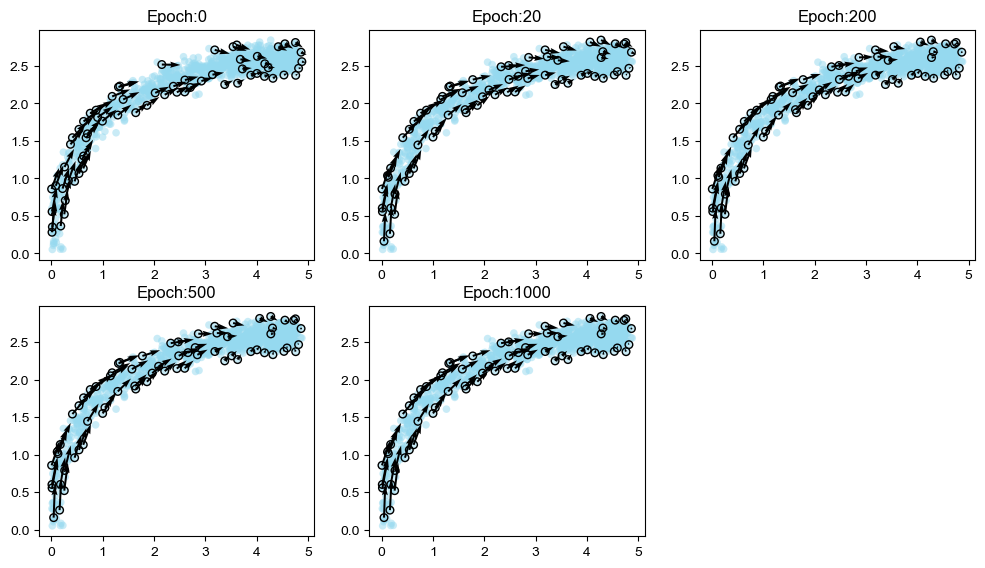

In [214]:

print("simulation alpha/beta", 5.2/2.0)
print("simulation alpha/gamma", 5.2/1.0)

ncols = 3
gene_list = ['gene1']
epoch_list = [0, 20, 200, 500, 1000]
fig = plt.figure(figsize=(4*ncols,4*len(epoch_list)/ncols))
for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    cellDancer_df = induction_result[induction_result.iteration == epoch]

    print("Epoch :", epoch)
    print("calculated alpha/beta:", cellDancer_df['alpha'][0]/cellDancer_df['beta'][0])
    print("calculated alpha/gamma:", cellDancer_df['alpha'][0]/cellDancer_df['gamma'][0])
    
    ax = fig.add_subplot(math.ceil(len(epoch_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        alpha=0.5, 
        s = 30,
        velocity=True,
        gene=gene_list[0])
    
    ax.set_title("Epoch:"+str(epoch))


## Velocity estimation for a whole cycle

In [202]:
#########################
# full 

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# =============================
# Use simulation data
# -  
alpha_true = 5.2
beta_true = 2.0
gamma_true = 1.0

u0, s0 = full_simulate(alpha_true, beta_true, gamma_true, t1=5, t2=5, samples1=1000, samples2=1000)
u0, s0 = jitter(u0, s0 )
# =============================
# Run nn model of pytorch step by step
# -
#alpha, beta, gamma = init_parameters(u0, s0)

alpha=4.0
beta=2.0
gamma=0.9
m = init_module(mode="full", alpha=alpha, beta=beta, gamma=gamma) #forward or full
#optimizer = optim.Adam(m.parameters(), lr=0.001, momentum=0.8)
optimizer = optim.Adam(m.parameters(), lr=0.001)

result = run_module(module=m, optimizer=optimizer, u0=u0, s0=s0, direct=None, times=1001, rept_freq=10)
result.rename(columns={'s0':'splice', 'u0':'unsplice', 'u1':'unsplice_predict','s1':'splice_predict'}, inplace=True)
result['gene_name']='gene2'

## Plot gene velocities 

simulation alpha/beta 2.6
simulation alpha/gamma 5.2
Epoch : 0
calculated alpha/beta: 2.0
calculated alpha/gamma: 4.4444447
Epoch : 20
calculated alpha/beta: 2.024674
calculated alpha/gamma: 4.512864
Epoch : 100
calculated alpha/beta: 2.1238446
calculated alpha/gamma: 4.73145
Epoch : 200
calculated alpha/beta: 2.274661
calculated alpha/gamma: 5.0606723
Epoch : 500
calculated alpha/beta: 2.4770947
calculated alpha/gamma: 5.070595
Epoch : 1000
calculated alpha/beta: 2.477236
calculated alpha/gamma: 5.071634


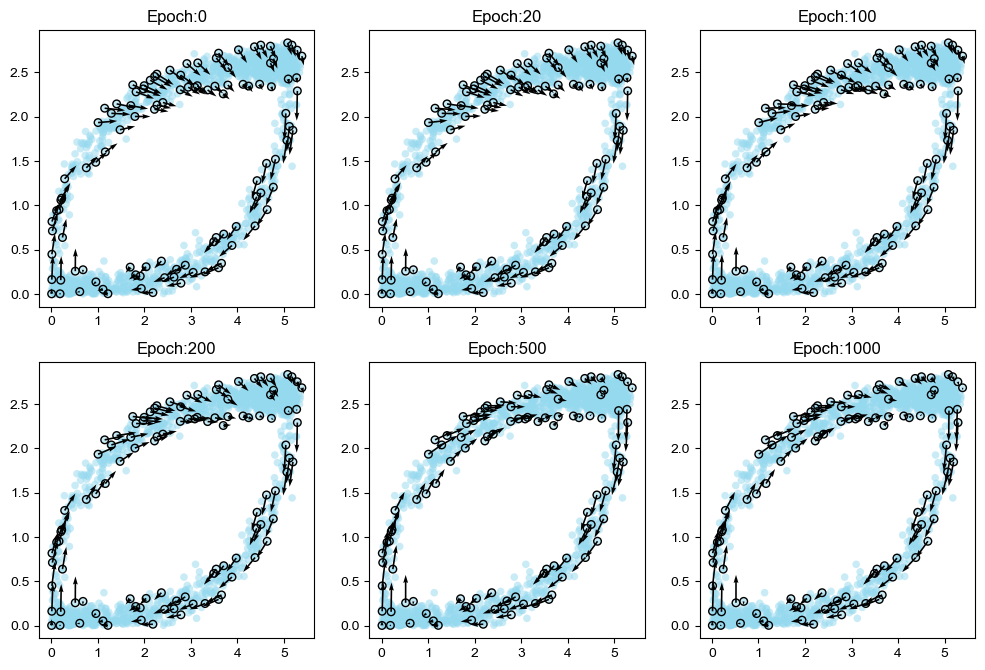

In [204]:
print("simulation alpha/beta", alpha_true/beta_true)
print("simulation alpha/gamma", alpha_true/gamma_true)


ncols = 3
gene_list = ['gene2']
epoch_list = [0, 20, 100, 200, 500, 1000]
fig = plt.figure(figsize=(4*ncols,4*len(epoch_list)/ncols))
for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    cellDancer_df = result[result.iteration == epoch]

    print("Epoch :", epoch)
    print("calculated alpha/beta:", cellDancer_df['alpha'][0]/cellDancer_df['beta'][0])
    print("calculated alpha/gamma:", cellDancer_df['alpha'][0]/cellDancer_df['gamma'][0])
    
    ax = fig.add_subplot(math.ceil(len(epoch_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        alpha=0.5, 
        s = 30,
        velocity=True,
        gene=gene_list[0])
    
    ax.set_title("Epoch:"+str(epoch))
    

In [198]:
result

,splice,unsplice,splice_predict,unsplice_predict,iteration,cost,alpha,beta,gamma,cost_mean,dt,gene_name
0,0.098390,0.056148,0.098413,0.060036,0,0.001285,4.000000,2.000000,0.900000,0.019329,0.001,gene2
0,0.098390,0.056148,0.098415,0.060064,10,0.001309,4.026494,1.964773,0.859544,0.018108,0.001,gene2
0,0.098390,0.056148,0.098419,0.060107,20,0.001346,4.066368,1.910167,0.796559,0.016794,0.001,gene2
0,0.098390,0.056148,0.098412,0.060147,30,0.001264,4.102131,1.827820,0.811730,0.015138,0.001,gene2
0,0.098390,0.056148,0.098406,0.060196,40,0.001180,4.145128,1.727234,0.820999,0.012513,0.001,gene2
...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0.210566,0.178079,0.210841,0.182187,460,0.007986,4.384051,1.545984,0.000000,0.032035,0.001,gene2
1664,0.210566,0.178079,0.210841,0.182187,470,0.007986,4.384051,1.545984,0.000000,0.032035,0.001,gene2
1664,0.210566,0.178079,0.210841,0.182187,480,0.007986,4.384051,1.545984,0.000000,0.032035,0.001,gene2
1664,0.210566,0.178079,0.210841,0.182187,490,0.007986,4.384051,1.545984,0.000000,0.032035,0.001,gene2
